__собираем статистики по объявлениям о продаже домов__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Пн 10 июн 2024 13:51:37 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_house.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

6858

,title,address,latitude,longitude,priceM,dt
2906,"дом, 173,9 м², 4 сот., ижс","севастополь,р-н балаклавский,с.орлиное,улица интернациональная,23",44.450801,33.781335,10.00,2024-06-07
6063,дом 117 м² на участке 4 сот.,"севастополь,монастырское ш.",44.530813,33.507223,7.09,2024-06-07
2350,"дом, 37,7 м², 2 сот., садоводство","севастополь,р-н гагаринский,сатурн садоводческое товарищество,152",44.558758,33.410187,6.00,2024-06-07


---

In [4]:
df_ = pd.read_pickle('data/2023/data_house.pkl').rename(columns={'adr':'address'})
df_['dt'] = df_['ts'].dt.date
display( len(df_) )
display( df_.sample(3)[cols] )

24429

,title,address,latitude,longitude,priceM,dt
10463,дом 82 м² на участке 6 сот.,"Севастополь,район Северная Сторона",44.630185,33.538206,9.30,2022-11-04
16829,дом 170 м² на участке 4 сот.,"Севастополь,ТСН СТ Фиолент",44.515022,33.476348,7.78,2022-11-28
1510,"дом 85 м² на участке 6,3 сот.","Севастополь,с. Суворово, Озёрная ул.",44.730706,33.626232,4.42,2022-09-15


In [5]:
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

24176

,title,address,latitude,longitude,priceM,dt,url
5431,дом 70 м² на участке 5 сот.,"Бахчисарай,с. Шевченково",44.863726,33.757449,3.00,2022-09-16,https://avito.ru/2501383565
22625,дом 104 м² на участке 5 сот.,"Севастополь,ТСН Верхняя Учкуевка",44.646951,33.552229,7.50,2024-06-05,https://avito.ru/3367871499
14438,дом 135 м² на участке 4 сот.,"Севастополь,территория ТСН СНТ Биолог, 24",44.555829,33.457079,8.10,2022-11-15,https://avito.ru/2427250248


In [6]:
# df_['dt'].drop_duplicates()


In [7]:
# history_date = df_['dt'].max()
history_date = pd.to_datetime('2023-01-10').date()
display(history_date)

datetime.date(2023, 1, 10)

In [8]:
df = pd.concat([df,df_]).reset_index(drop=True)
display( len(df) )
del df_

31034

---

In [9]:
# df['dt'].drop_duplicates().sort_values()

In [10]:
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-04').date() ]
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-05').date() ]
# display( len(df) )
# df = df.reset_index(drop=True)

---

In [11]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31034 entries, 0 to 31033
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   url                  31034 non-null  object        
 1   place                31034 non-null  object        
 2   title                31034 non-null  object        
 3   subtitle             3085 non-null   object        
 4   price                31034 non-null  int64         
 5   address              31034 non-null  object        
 6   description          31034 non-null  object        
 7   ts                   31034 non-null  datetime64[ns]
 8   house_area           31034 non-null  float64       
 9   is_part              31034 non-null  bool          
 10  is_townhouse         31034 non-null  bool          
 11  is_SNT               31034 non-null  bool          
 12  land_area            31034 non-null  float64       
 13  priceM               31034 non-

In [13]:
df.loc[ df['address']=='квартал Старый Город', ['latitude','longitude']] = None
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 

df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [14]:
df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'

In [15]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

31034

30993

In [16]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_part) & (house_area>40.) & (priceM<15.)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

30993

21916

21879

In [17]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt,url
29592,дача 50 м² на участке 4 сот.,"Севастополь,ТСН СТ Морзаводец, Абрикосовая ул.",44.54,33.57,4.50,2024-06-05,https://avito.ru/4024217572
4449,"дом 170 м² на участке 4,3 сот.","севастополь,ст дерзкий",44.74,33.56,11.00,2024-06-10,https://www.avito.ru/3857580678
3852,дом 195 м² на участке 5 сот.,"севастополь,тсн ст дружба",44.59,33.59,5.70,2024-06-10,https://www.avito.ru/3797482443


---

In [18]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
display( dt_min,history_date,dt_max )

datetime.date(2022, 9, 15)

datetime.date(2023, 1, 10)

datetime.date(2024, 6, 10)

In [19]:
gdf = gdf.query('place in ("bahchisaray","sudak","sevastopol")')

In [20]:
gdf_history = gdf.query(f'dt <= @history_date')
gdf = gdf.query(f'dt > @history_date')

In [22]:
display( len(gdf_history) )
display( len(gdf) )

14235

7622

---

In [23]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [24]:
# gdf['place'].unique()

# общая статистика

In [25]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [26]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [27]:
# gdf[ gdf['address'].str.match(r'.*ялта.*') ]
# gdf[ gdf['address'].str.match(r'.*окуневка.*') ]
# gdf[ gdf['address'].str.match(r'.*заветное.*') ]

In [28]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [29]:
# cols = ['title','adr','priceM','house_size_category','place','url','geometry']

In [30]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = gdf.groupby(['place','house_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
stat_history = gdf_history.groupby(['place','house_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)

display( stat )
display( stat_history )

count  mean  std   min    1%  \
place       house_size_category dt                                          
bahchisaray 30-50               2024-06-04   28.00  3.77 1.44  2.00  2.00   
                                2024-06-05   29.00  3.78 1.40  2.00  2.00   
                                2024-06-07   29.00  3.92 1.61  2.00  2.06   
                                2024-06-10   30.00  3.93 1.58  2.00  2.06   
            50-70               2024-06-04   65.00  5.55 1.97  1.80  1.80   
                                2024-06-05   67.00  5.62 1.98  1.80  1.80   
                                2024-06-07   70.00  5.57 1.92  1.80  1.80   
                                2024-06-10   71.00  5.75 2.09  1.80  1.80   
            70-150              2024-06-04   96.00  7.10 3.20  1.50  1.64   
                                2024-06-05   99.00  7.06 3.19  1.50  1.65   
                                2024-06-07   96.00  6.99 3.17  1.50  1.64   
                                2024-06-10   96.00  6.83 3.13  1.50  1.64   
            150-300             2024-06-04   38.00  9.28 3.31  2.30  2.93   
                                2024-06-05   39.00  9.30 3.28  2.30  2.95   
                                2024-06-07   41.00  9.37 3.21  2.30  2.98   
                                2024-06-10   39.00  9.26 3.14  2.30  2.95   
            300+                2024-06-04    4.00 12.25 1.71 10.00 10.06   
                                2024-06-05    4.00 12.25 1.71 10.00 10.06   
                                2024-06-07    4.00 12.25 1.71 10.00 10.06   
                                2024-06-10    5.00 12.40 1.52 10.00 10.08   
sevastopol  30-50               2024-06-04   65.00  5.22 2.10  1.90  1.93   
                                2024-06-05   56.00  5.38 2.37  1.90  1.93   
                                2024-06-07  110.00  5.21 1.87  1.90  2.00   
                                2024-06-10  100.00  5.30 1.80  1.90  2.49   
            50-70               2024-06-04  125.00  6.26 2.17  2.29  3.27   
                                2024-06-05  130.00  6.20 2.14  2.29  2.92   
                                2024-06-07  294.00  6.26 2.11  2.29  2.69   
                                2024-06-10  298.00  6.39 2.19  1.37  2.69   
            70-150              2024-06-04  645.00  8.75 2.59  1.43  3.20   
                                2024-06-05  657.00  8.71 2.63  1.43  3.20   
                                2024-06-07 1415.00  8.51 2.38  1.43  3.32   
                                2024-06-10 1412.00  8.51 2.38  1.43  3.21   
            150-300             2024-06-04  165.00 10.84 2.72  3.59  3.95   
                                2024-06-05  168.00 10.92 2.73  3.59  4.08   
                                2024-06-07  269.00 10.46 2.54  3.50  4.08   
                                2024-06-10  281.00 10.50 2.54  3.50  4.09   
            300+                2024-06-04    4.00  9.97 4.44  4.50  4.62   
                                2024-06-05    4.00  9.97 4.44  4.50  4.62   
                                2024-06-07    8.00  8.35 3.76  3.80  3.85   
                                2024-06-10   12.00  8.97 3.29  3.80  3.88   
sudak       30-50               2024-06-04    3.00  5.33 1.90  3.99  4.00   
                                2024-06-05    3.00  5.33 1.90  3.99  4.00   
                                2024-06-07   10.00  9.20 3.66  3.99  4.04   
                                2024-06-10   10.00  9.20 3.66  3.99  4.04   
            50-70               2024-06-04   15.00  7.73 2.90  4.50  4.51   
                                2024-06-05   15.00  7.73 2.90  4.50  4.51   
                                2024-06-07   21.00  7.46 2.27  4.50  4.52   
                                2024-06-10   19.00  7.47 2.39  4.50  4.52   
            70-150              2024-06-04   50.00  8.17 2.87  2.80  3.00   
                                2024-06-05   49.00  8.15 2.90  2.80  2.99   
                                2024-06-0

count  mean  std  min   1%   5%  \
place       house_size_category dt                                            
bahchisaray 30-50               2022-09-15  34.00  3.48 1.41 1.60 1.63 1.77   
                                2022-09-16  37.00  3.41 1.39 1.60 1.64 1.78   
                                2022-10-14  33.00  3.21 1.24 1.50 1.56 1.70   
                                2022-11-07  31.00  3.09 1.22 1.39 1.42 1.65   
                                2022-11-15  34.00  3.34 1.33 1.39 1.43 1.69   
...                                           ...   ...  ...  ...  ...  ...   
sudak       300+                2022-10-14   3.00  9.33 0.58 9.00 9.00 9.00   
                                2022-11-07   2.00  9.00 0.00 9.00 9.00 9.00   
                                2022-11-15   2.00  9.00 0.00 9.00 9.00 9.00   
                                2022-11-28   3.00 10.27 2.19 9.00 9.00 9.00   
                                2023-01-10   3.00 10.27 2.19 9.00 9.00 9.00   

                                            10%  25%  50%   75%   90%   max  
place       house_size_category dt                                           
bahchisaray 30-50               2022-09-15 2.00 2.50 3.40  4.00  4.64  7.90  
                                2022-09-16 1.92 2.50 3.30  4.00  4.58  7.90  
                                2022-10-14 1.80 2.48 2.85  3.90  4.66  7.00  
                                2022-11-07 1.80 2.34 2.60  3.85  4.70  6.00  
                                2022-11-15 1.86 2.50 3.00  3.90  5.35  7.00  
...                                         ...  ...  ...   ...   ...   ...  
sudak       300+                2022-10-14 9.00 9.00 9.00  9.50  9.80 10.00  
                                2022-11-07 9.00 9.00 9.00  9.00  9.00  9.00  
                                2022-11-15 9.00 9.00 9.00  9.00  9.00  9.00  
                                2022-11-28 9.00 9.00 9.00 10.90 12.04 12.80  
                                2023-01-10 9.00 9.00 9.00 10.90 12.04 12.80  

[130 rows x 12 columns]

In [31]:
# percentiles=[.01,.05,.1,.25,.5,.75,.9]
# stat = gdf.groupby(['place','house_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
# display( stat )

In [32]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%']
sizes = stat.reset_index()['house_size_category'].unique()
sizes = ['50-70', '70-150', '150-300' ]
display(sizes)

['50-70', '70-150', '150-300']

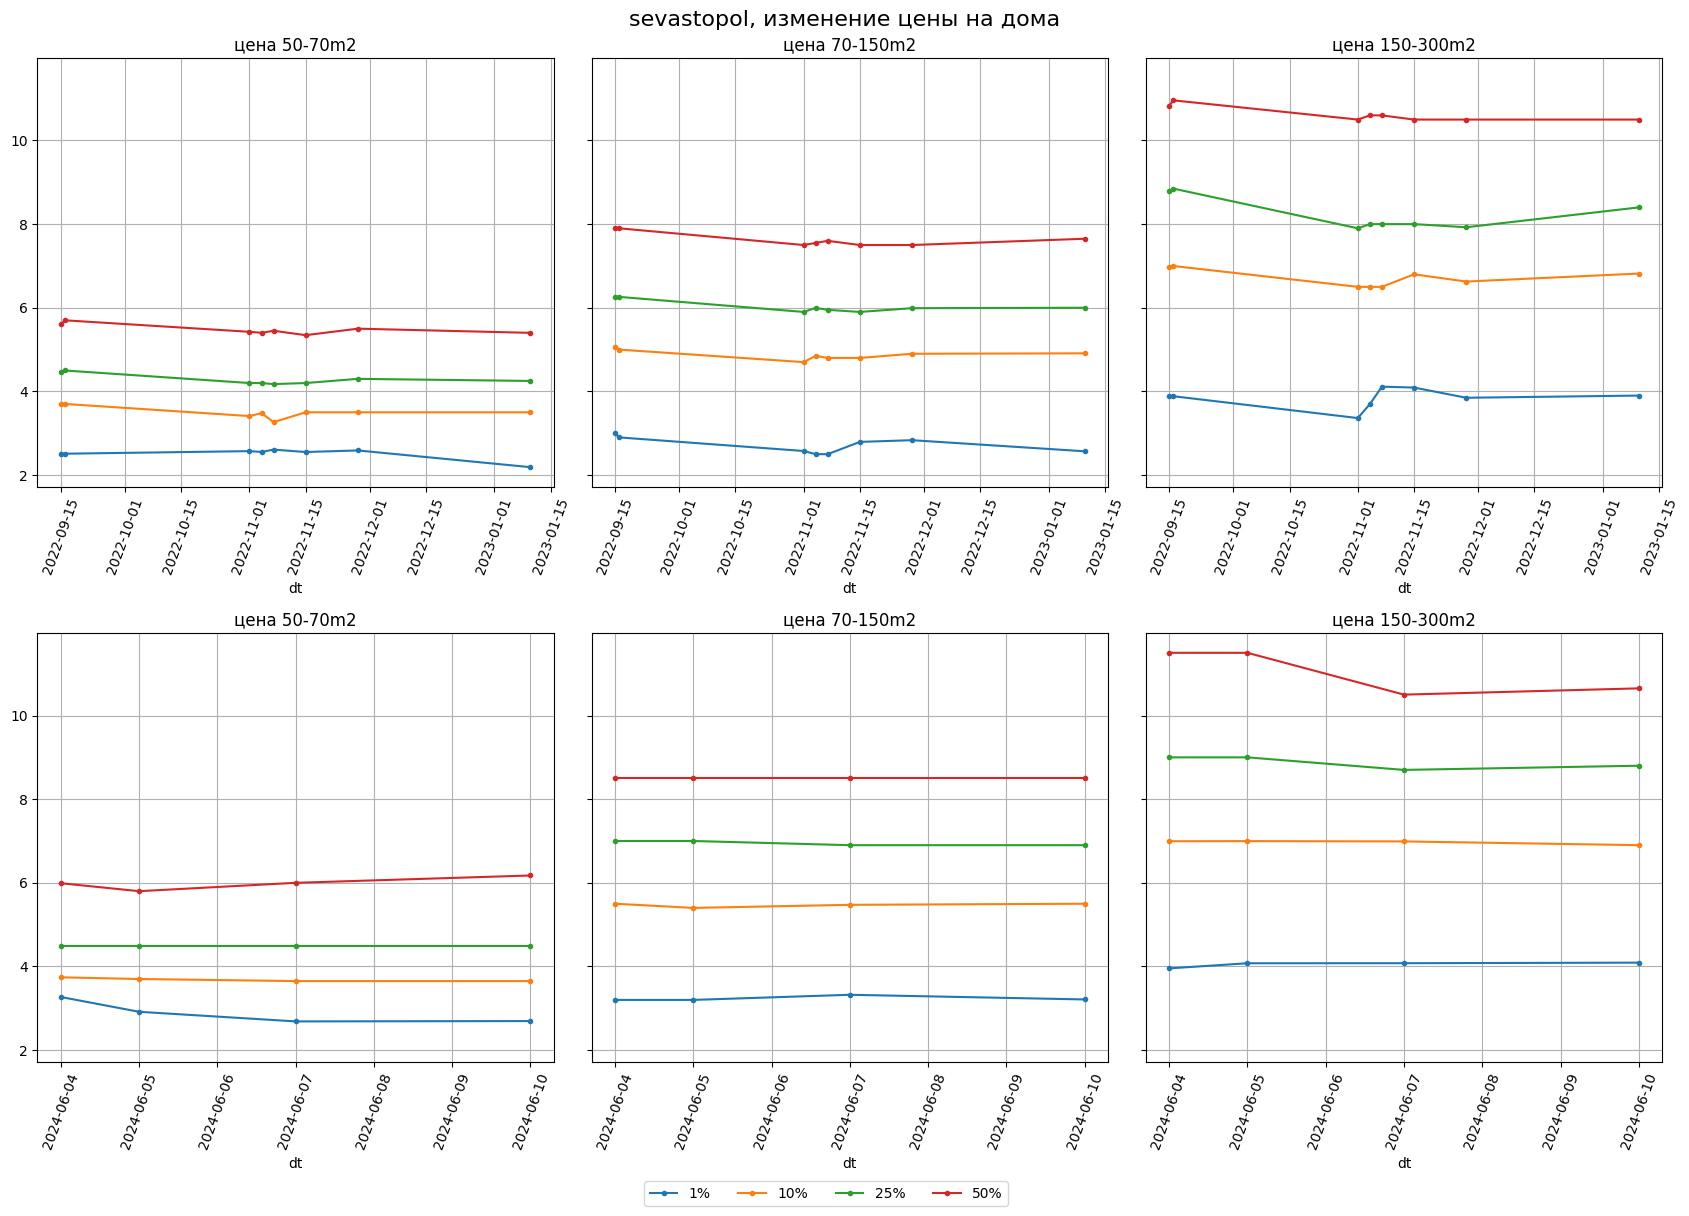

In [33]:
place = 'sevastopol'

fig, ax = plt.subplots(2,len(sizes),figsize=(17,12), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[1][i],legend=False, rot=70, style='.-' )   
    stat_history.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[0][i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [ ]:
place = 'sudak'

fig, ax = plt.subplots(2,len(sizes),figsize=(17,12), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[1][i],legend=False, rot=70, style='.-' )   
    stat_history.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[0][i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

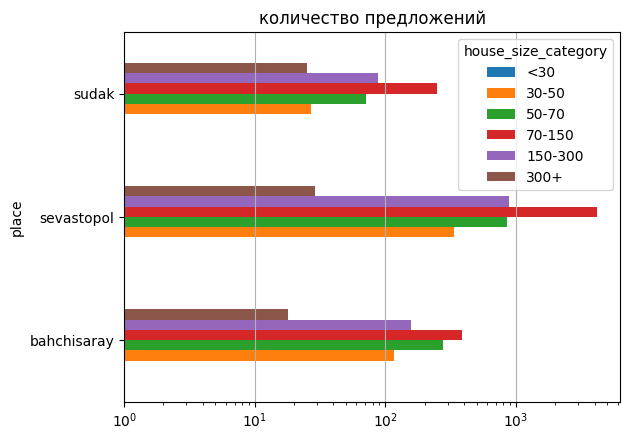

In [34]:
(
gdf
.groupby(['house_size_category','place'],observed=False)['url'].count().reset_index()
# .query('place in ("bahchisaray","sudak","sevastopol")')
.pivot(index='place', columns='house_size_category', values='url')
.plot.barh(title='количество предложений',log=True)
.grid(axis='x')    
)

# актуальная цена

In [35]:
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == gdf['dt'].max() ]
display(len(gdf_last))

7622

2479

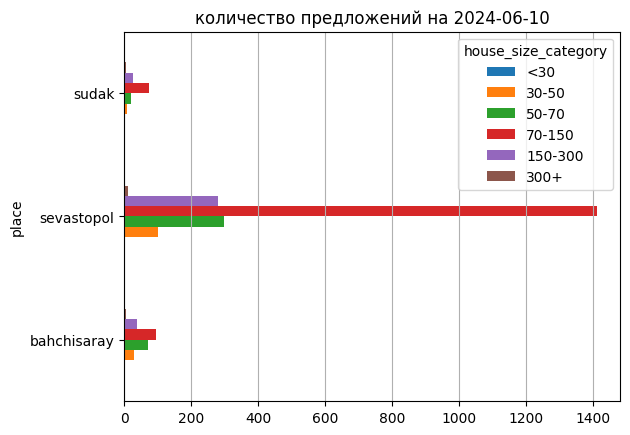

In [36]:
(
gdf_last
.groupby(['house_size_category','place'],observed=False)['url'].count().reset_index()
.pivot(index='place', columns='house_size_category', values='url')
.plot.barh(title='количество предложений на '+ str( gdf['dt'].max() ))
.grid(axis='x')    
)

In [37]:
(
    gdf_last
    .groupby(['place','house_size_category'],observed=False)
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std   min    1%    5%   10%  \
place       house_size_category                                              
bahchisaray 30-50                 30.00  3.93 1.58  2.00  2.06  2.21  2.29   
            50-70                 71.00  5.75 2.09  1.80  1.80  2.65  3.30   
            70-150                96.00  6.83 3.13  1.50  1.64  2.40  2.98   
            150-300               39.00  9.26 3.14  2.30  2.95  4.00  4.94   
            300+                   5.00 12.40 1.52 10.00 10.08 10.40 10.80   
sevastopol  30-50                100.00  5.30 1.80  1.90  2.49  2.79  3.38   
            50-70                298.00  6.39 2.19  1.37  2.69  3.50  3.65   
            70-150              1412.00  8.51 2.38  1.43  3.21  4.58  5.50   
            150-300              281.00 10.50 2.54  3.50  4.09  6.15  6.90   
            300+                  12.00  8.97 3.29  3.80  3.88  4.18  4.60   
sudak       30-50                 10.00  9.20 3.66  3.99  4.04  4.22  4.45   
            50-70                 19.00  7.47 2.39  4.50  4.52  4.59  4.68   
            70-150                75.00  8.69 2.86  2.80  3.10  4.44  4.58   
            150-300               25.00 10.37 3.77  4.00  4.05  4.26  5.08   
            300+                   6.00 11.08 1.83  9.00  9.00  9.00  9.00   

                                  25%   50%   75%   90%   max  
place       house_size_category                                
bahchisaray 30-50                2.50  3.90  4.86  5.55  9.00  
            50-70                4.55  5.50  7.20  8.90 10.00  
            70-150               4.65  6.50  8.60 11.65 14.00  
            150-300              6.50 10.00 11.15 13.50 14.55  
            300+                12.00 13.00 13.00 13.60 14.00  
sevastopol  30-50                3.95  5.10  6.50  7.32 11.00  
            50-70                4.50  6.18  7.72  9.42 14.00  
            70-150               6.90  8.50 10.00 11.50 14.90  
            150-300              8.80 10.65 12.00 13.80 15.00  
            300+                 7.82  9.00 10.05 12.90 14.80  
sudak       30-50                7.12  8.35 12.85 13.41 13.50  
            50-70                4.92  7.50  8.30 10.94 12.50  
            70-150               6.47  8.50 11.35 12.40 13.50  
            150-300              7.00 10.30 13.80 14.93 14.99  
            300+                 9.50 11.25 12.25 13.00 13.50

# цены на карте

In [38]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [39]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [40]:
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# gdf_last.query('place=="sevastopol"')[cols]

In [41]:
# gdf_last[gdf_last['place']=='sevastopol'][cols]

## Севастополь

In [42]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [43]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## Судак

In [44]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sudak.explore()

In [45]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [46]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [47]:
display(frames)

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка (старый)","POLYGON ((33.52932 44.59395, 33.53014 44.59336, 33.53265 44.59419, 33.53374 44.59431, 33.53651 44.59412, 33.54230 44.59142, 33.54644 44.58708, 33.54577 44.58522, 33.54406 44.58269, 33.54076 44.58366, 33.53883 44.58383, 33.53664 44.58511, 33.53142 44.58626, 33.53025 44.58780, 33.53048 44.58861, 33.53046 44.58847, 33.53167 44.59039, 33.53092 44.59122, 33.52951 44.59116, 33.52879 44.59244, 33.52895 44.59355, 33.52932 44.59395))"
6,"Севастополь, кр.горка (новый)","POLYGON ((33.54571 44.58517, 33.54652 44.58705, 33.54904 44.58565, 33.55000 44.58541, 33.55054 44.58522, 33.55089 44.58423, 33.55253 44.58415, 33.55326 44.58470, 33.55368 44.58431, 33.55371 44.58320, 33.55522 44.58246, 33.55548 44.58219, 33.55564 44.58115, 33.55564 44.58115, 33.55644 44.58055, 33.55694 44.57984, 33.55718 44.57912, 33.55936 44.57821, 33.56045 44.57706, 33.56229 44.57552, 33.56283 44.57476, 33.55749 44.57202, 33.55674 44.57395, 33.55618 44.57483, 33.55600 44.57601, 33.55286 44.57827, 33.55293 44.57910, 33.55259 44.58172, 33.55269 44.58302, 33.55003 44.58331, 33.54838 44.58436, 33.54571 44.58509, 33.54571 44.58517))"
7,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"
8,"Севастополь, Благополучный","POLYGON ((33.56498 44.57145, 33.56348 44.57083, 33.56274 44.57070, 33.56182 44.57017, 33.56179 44.56990, 33.55967 44.56941, 33.55751 44.57190, 33.55756 44.57213, 33.56302 44.57463, 33.56498 44.57145))"


In [48]:
frames.explore('area_name', legend=True)

In [49]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
'Севастополь, кр.горка (старый)',
'Севастополь, кр.горка (новый)',
'Севастополь, Благополучный',
]

In [50]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_ = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_[['title','priceM','address','geometry']].explore( legend=False)

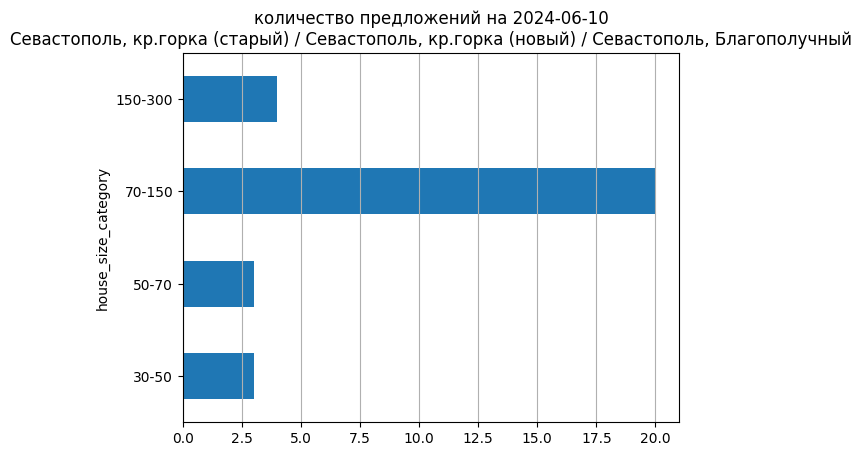

In [51]:
(
    gdf_
    .groupby(['house_size_category'], observed=True)['url'].count()
    .plot.barh(title='количество предложений на '+ str( gdf['dt'].max()) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')    
)

----

In [52]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 
gdf_local_history = gdf_history.sjoin( frame_, how='inner', predicate='within') 

In [53]:
# stat = gdf_local.groupby(['house_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
# display( stat )

In [54]:
# sizes = [ '50-70', '70-150', '150-300', ]

In [60]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = (
        gdf_local
        .groupby(['house_size_category','dt'],observed=True)
        ['priceM'].describe(percentiles=percentiles)
        #.dropna()
    )
stat_history = (
        gdf_local_history
        .groupby(['house_size_category','dt'],observed=True)
        ['priceM'].describe(percentiles=percentiles)
        #.dropna()
    )

display( stat )
display( stat_history )

count  mean  std   min    1%    5%   10%  \
house_size_category dt                                                     
30-50               2024-06-04   1.00  5.85  NaN  5.85  5.85  5.85  5.85   
                    2024-06-05   1.00  5.85  NaN  5.85  5.85  5.85  5.85   
                    2024-06-07   3.00  5.90 0.09  5.85  5.85  5.85  5.85   
                    2024-06-10   3.00  5.90 0.09  5.85  5.85  5.85  5.85   
50-70               2024-06-04   1.00  6.35  NaN  6.35  6.35  6.35  6.35   
                    2024-06-05   1.00  6.35  NaN  6.35  6.35  6.35  6.35   
                    2024-06-07   3.00  7.27 0.79  6.35  6.38  6.49  6.62   
                    2024-06-10   3.00  8.36 2.39  6.35  6.38  6.49  6.62   
70-150              2024-06-04  14.00  8.77 2.42  5.40  5.41  5.46  5.50   
                    2024-06-05  13.00  8.70 2.50  5.40  5.41  5.46  5.50   
                    2024-06-07  20.00  8.11 2.40  5.22  5.23  5.25  5.39   
                    2024-06-10  20.00  7.85 1.97  5.22  5.23  5.25  5.39   
150-300             2024-06-04   3.00 12.58 2.49 10.00 10.05 10.28 10.55   
                    2024-06-05   3.00 12.58 2.49 10.00 10.05 10.28 10.55   
                    2024-06-07   4.00 11.25 3.79  6.50  6.61  7.03  7.55   
                    2024-06-10   4.00 11.25 3.79  6.50  6.61  7.03  7.55   

                                 25%   50%   75%   90%   max  
house_size_category dt                                        
30-50               2024-06-04  5.85  5.85  5.85  5.85  5.85  
                    2024-06-05  5.85  5.85  5.85  5.85  5.85  
                    2024-06-07  5.85  5.85  5.92  5.97  6.00  
                    2024-06-10  5.85  5.85  5.92  5.97  6.00  
50-70               2024-06-04  6.35  6.35  6.35  6.35  6.35  
                    2024-06-05  6.35  6.35  6.35  6.35  6.35  
                    2024-06-07  7.04  7.72  7.72  7.72  7.72  
                    2024-06-10  7.04  7.72  9.36 10.35 11.00  
70-150              2024-06-04  7.00  9.25  9.71 10.91 14.00  
                    2024-06-05  6.50  8.90  9.60 11.04 14.00  
                    2024-06-07  6.25  8.50  9.60 10.13 14.00  
                    2024-06-10  6.25  8.40  9.60 10.00 11.30  
150-300             2024-06-04 11.38 12.75 13.87 14.53 14.98  
                    2024-06-05 11.38 12.75 13.87 14.53 14.98  
                    2024-06-07  9.12 11.75 13.87 14.54 14.98  
                    2024-06-10  9.12 11.75 13.87 14.54 14.98

count  mean  std   min    1%    5%   10%  \
house_size_category dt                                                     
50-70               2022-09-15   3.00  8.00 0.87  7.00  7.03  7.15  7.30   
                    2022-09-16   4.00  7.12 1.89  4.50  4.57  4.87  5.25   
                    2022-11-01   3.00  6.90 1.39  6.00  6.00  6.02  6.04   
                    2022-11-04   2.00  7.50 1.41  6.50  6.52  6.60  6.70   
                    2022-11-07   3.00  6.23 0.25  6.00  6.00  6.02  6.04   
                    2022-11-15   1.00  6.20  NaN  6.20  6.20  6.20  6.20   
                    2022-11-28   2.00  6.58 0.53  6.20  6.21  6.24  6.28   
                    2023-01-10   4.00  7.04 1.15  5.50  5.54  5.72  5.94   
70-150              2022-09-15  20.00  8.00 2.73  5.50  5.50  5.50  5.50   
                    2022-09-16  20.00  7.89 2.76  5.50  5.50  5.50  5.68   
                    2022-11-01  25.00  6.63 2.08  3.00  3.38  4.66  5.02   
                    2022-11-04  22.00  6.39 2.03  3.00  3.33  4.62  5.12   
                    2022-11-07  22.00  6.25 1.48  3.00  3.33  4.62  5.12   
                    2022-11-15  22.00  6.47 1.63  3.00  3.45  5.12  5.12   
                    2022-11-28  25.00  6.41 1.66  2.80  3.21  4.50  4.75   
                    2023-01-10  27.00  7.86 3.03  2.70  3.28  4.92  4.96   
150-300             2022-09-15   7.00  9.97 3.03  6.50  6.55  6.74  6.98   
                    2022-09-16   9.00 10.26 2.71  6.50  6.56  6.82  7.14   
                    2022-11-01  10.00 10.14 2.55  6.50  6.55  6.77  7.04   
                    2022-11-04   8.00 10.88 2.29  6.50  6.70  7.52  8.53   
                    2022-11-07   8.00  9.87 2.95  6.50  6.51  6.57  6.64   
                    2022-11-15   6.00 11.74 2.69  7.00  7.17  7.88  8.75   
                    2022-11-28  10.00 11.56 3.20  6.00  6.04  6.22  6.45   
                    2023-01-10   6.00 10.28 2.76  6.50  6.60  7.00  7.50   
300+                2022-11-01   1.00 14.80  NaN 14.80 14.80 14.80 14.80   
                    2022-11-07   1.00 14.80  NaN 14.80 14.80 14.80 14.80   
                    2022-11-15   1.00 14.80  NaN 14.80 14.80 14.80 14.80   
                    2022-11-28   1.00 14.80  NaN 14.80 14.80 14.80 14.80   

                                 25%   50%   75%   90%   max  
house_size_category dt                                        
50-70               2022-09-15  7.75  8.50  8.50  8.50  8.50  
                    2022-09-16  6.37  7.75  8.50  8.50  8.50  
                    2022-11-01  6.10  6.20  7.35  8.04  8.50  
                    2022-11-04  7.00  7.50  8.00  8.30  8.50  
                    2022-11-07  6.10  6.20  6.35  6.44  6.50  
                    2022-11-15  6.20  6.20  6.20  6.20  6.20  
                    2022-11-28  6.39  6.58  6.76  6.88  6.95  
                    2023-01-10  6.59  7.22  7.67  7.99  8.20  
70-150              2022-09-15  6.00  7.05  9.11 13.05 14.00  
                    2022-09-16  5.94  6.45  9.11 13.05 14.00  
                    2022-11-01  5.70  6.00  7.40  8.85 13.50  
                    2022-11-04  5.70  5.90  7.00  8.39 13.50  
                    2022-11-07  5.27  5.90  7.20  8.49  8.95  
                    2022-11-15  5.71  6.00  7.35  8.50  9.60  
                    2022-11-28  5.70  6.00  7.40  8.77  9.60  
                    2023-01-10  5.88  7.20  9.27 12.74 14.30  
150-300             2022-09-15  7.32  9.80 12.38 13.29 14.10  
                    2022-09-16  7.35 10.50 12.00 13.02 14.10  
                    2022-11-01  7.83 10.68 11.74 12.88 14.10  
                    2022-11-04 10.22 10.90 12.19 13.15 14.10  
                    2022-11-07  6.92  9.95 12.19 13.15 14.10  
                    2022-11-15 10.88 12.38 13.76 14.10 14.10  
                    2022-11-28 10.03 12.38 14.05 14.18 14.90  
                    2023-01-10  8.60 10.40 11.97 12.95 13.90  
300+                2022-11-01 14.80 14.80 14.80 14.80 14.80  
                    2022-11-07 14.80 14.80 14.80 1

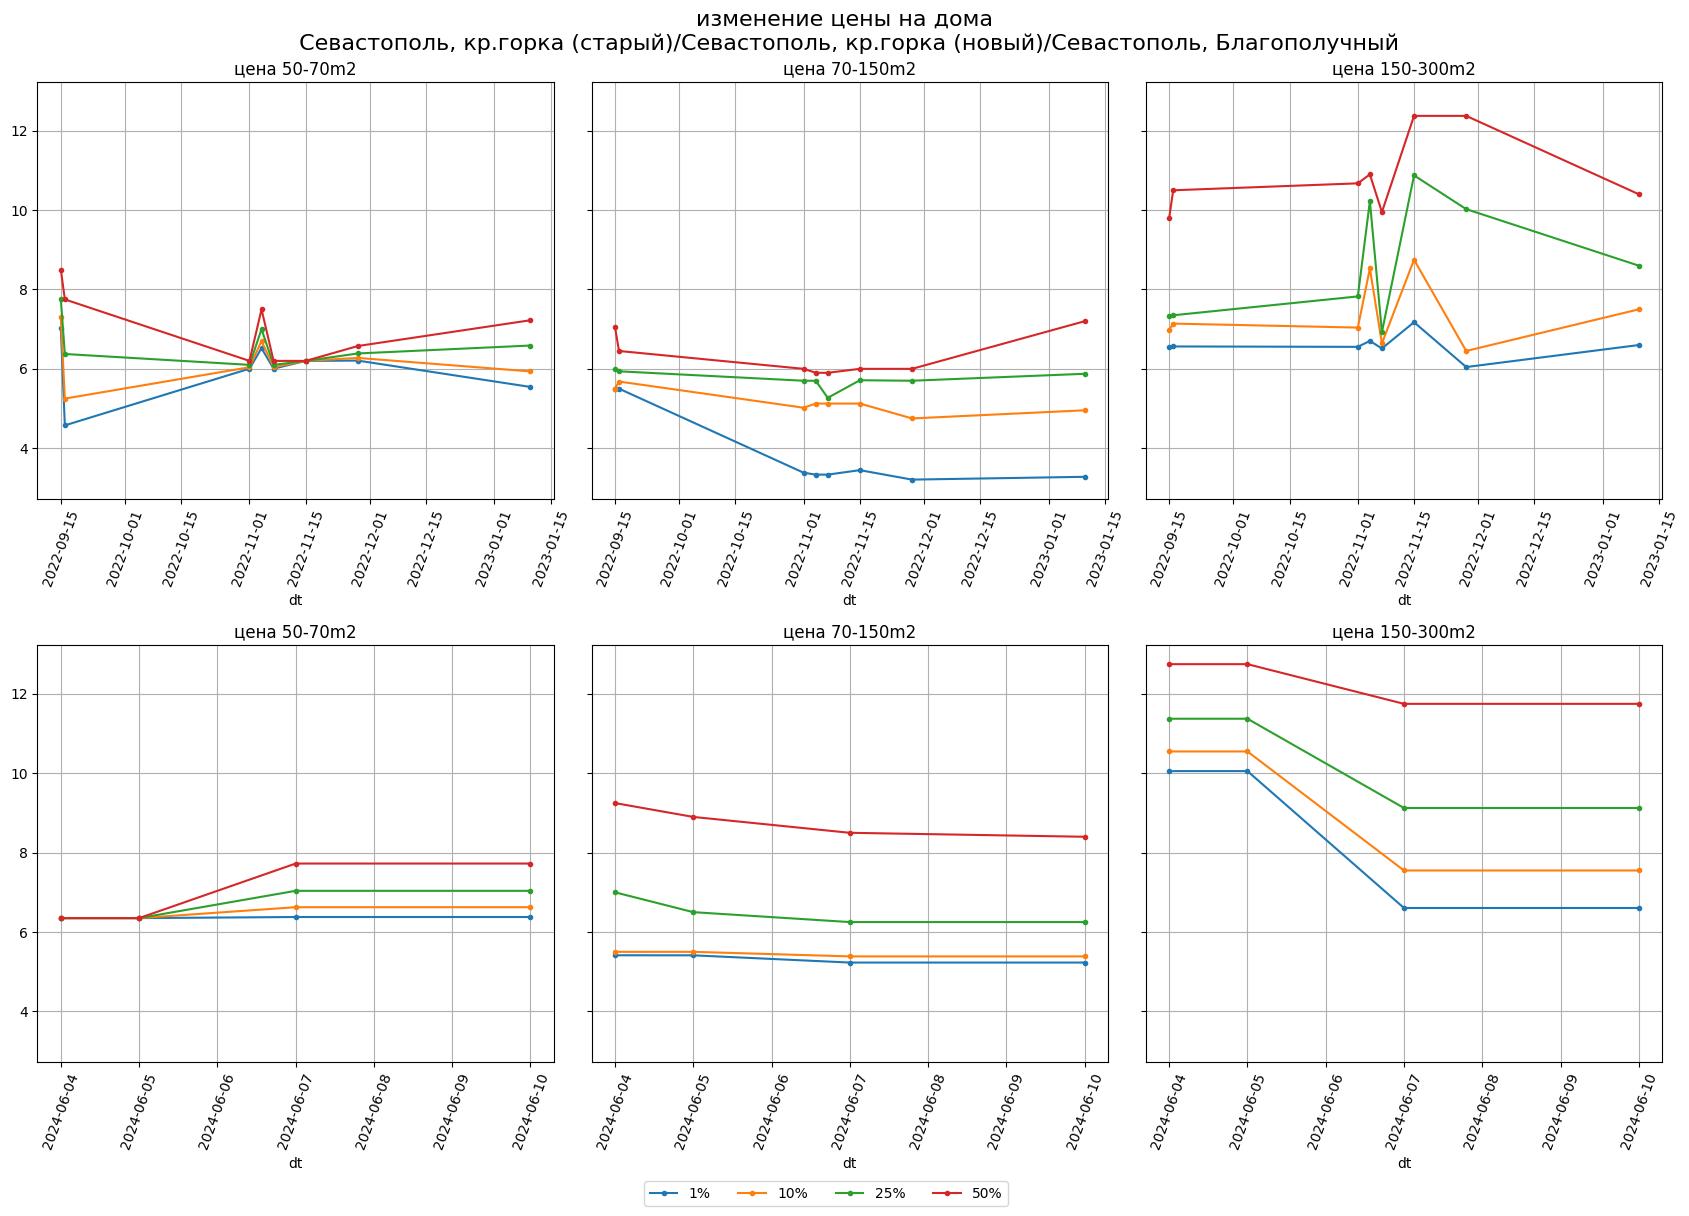

In [61]:
fig, ax = plt.subplots(2,len(sizes),figsize=(17,12), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[1][i],legend=False, rot=70, style='.-' )   
    stat_history.loc[(s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[0][i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на дома\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [62]:
# # import matplotlib.pyplot as plt
# # sizes = stat.reset_index()['house_size_category'].unique()
# cols = ['1%','10%','25%','50%']

# fig, ax = plt.subplots(1,len(sizes),figsize=(15,5), sharey=True )
# for i,s in enumerate(sizes): 
#     stat.loc[(s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

# fig.suptitle(f'изменение цены на дома\n {'/'.join(area_name)}', fontsize=16)
# fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
# fig.tight_layout()